Default estimator and WoE binning 

In [68]:
import sys
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xverse.transformer import WOE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# Add the correct relative path to the scripts folder
sys.path.append(os.path.abspath('../scripts'))
sys.path.append(os.path.abspath('../data'))

In [69]:
data = pd.read_csv(r'C:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\data\cleaned.csv')

In [70]:
data.head()

,Unnamed: 0,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


Compute RFMS Features

In [71]:
# Compute Recency (days since last transaction)
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
max_date = data['TransactionStartTime'].max()
data['Recency'] = (max_date - data['TransactionStartTime']).dt.days

# Compute Frequency (number of transactions per user)
frequency = data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']

# Compute Monetary (total transaction amount per user)
monetary = data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary.columns = ['CustomerId', 'Monetary']

# Merge Recency, Frequency, and Monetary into a single DataFrame
rfm = data[['CustomerId', 'Recency']].drop_duplicates().merge(frequency, on='CustomerId').merge(monetary, on='CustomerId')

# Display the first few rows of the RFMS features
rfm.head()


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_4406,90,119,109921.75
1,CustomerId_4683,90,2,1000.00
2,CustomerId_988,90,38,228727.20
3,CustomerId_1432,90,1,2000.00
4,CustomerId_2858,90,29,93400.00


Establish Boundaries (Good vs. Bad)

In [72]:
# Define thresholds for high risk (bad) users based on Recency, Frequency, and Monetary
recency_threshold = rfm['Recency'].quantile(0.75)  # Users in the top 25% of Recency
frequency_threshold = rfm['Frequency'].quantile(0.25)  # Users in the bottom 25% of Frequency
monetary_threshold = rfm['Monetary'].quantile(0.25)  # Users in the bottom 25% of Monetary

# Classify users as Good (0) or Bad (1)
rfm['Risk'] = ((rfm['Recency'] > recency_threshold) & 
               (rfm['Frequency'] < frequency_threshold) & 
               (rfm['Monetary'] < monetary_threshold)).astype(int)

# Display the distribution of risk labels
rfm['Risk'].value_counts()


Risk
0    21110
1     1043
Name: count, dtype: int64

In [73]:
rfm

,CustomerId,Recency,Frequency,Monetary,Risk
0,CustomerId_4406,90,119,109921.75,0
1,CustomerId_4683,90,2,1000.00,1
2,CustomerId_988,90,38,228727.20,0
3,CustomerId_1432,90,1,2000.00,1
4,CustomerId_2858,90,29,93400.00,0
...,...,...,...,...,...
22148,CustomerId_1579,0,20,90000.00,0
22149,CustomerId_1681,0,13,50000.00,0
22150,CustomerId_2067,0,1,2000.00,0
22151,CustomerId_539,0,16,22610.00,0


Visualization of RFMS in the Space

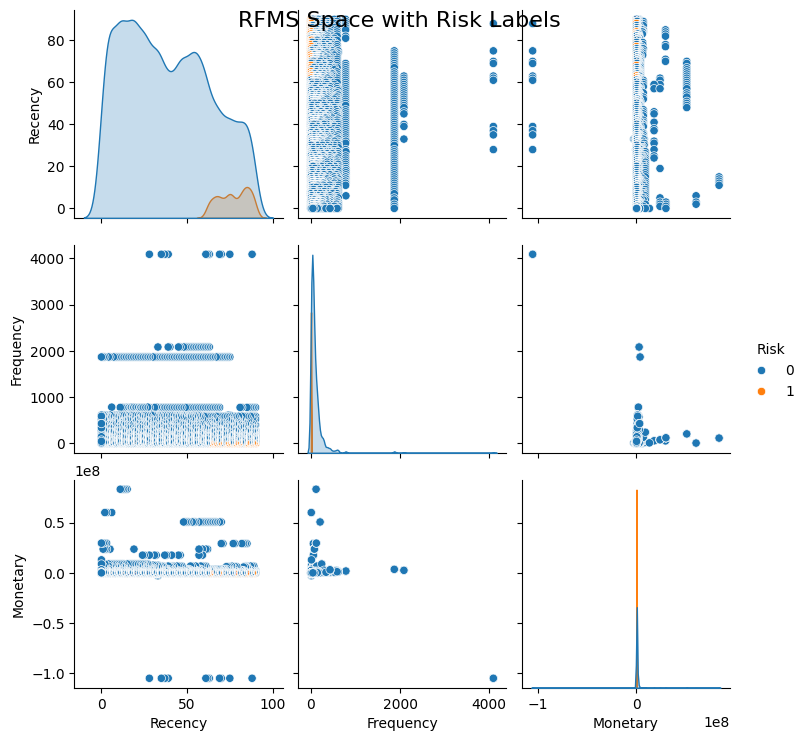

In [74]:
# Pairplot to visualize RFMS space
sns.pairplot(rfm, hue='Risk', vars=['Recency', 'Frequency', 'Monetary'])
plt.suptitle('RFMS Space with Risk Labels', fontsize=16)
plt.show()

WoE Binning for Recency, Frequency, and Monetary

In [75]:
# Initialize WoE binning transformer
woe_transformer = WOE()

# Bin the RFMS features using pd.cut()
rfm_binned = rfm.copy()

# Ensure that the bins are correctly created for Recency, Frequency, and Monetary
rfm_binned['Recency_bin'] = pd.cut(rfm['Recency'], bins=5)
rfm_binned['Frequency_bin'] = pd.cut(rfm['Frequency'], bins=5)
rfm_binned['Monetary_bin'] = pd.cut(rfm['Monetary'], bins=5)

# Initialize label encoder
le = LabelEncoder()

# Encode the binned categories as numeric values
rfm_binned['Recency_bin'] = le.fit_transform(rfm_binned['Recency_bin'])
rfm_binned['Frequency_bin'] = le.fit_transform(rfm_binned['Frequency_bin'])
rfm_binned['Monetary_bin'] = le.fit_transform(rfm_binned['Monetary_bin'])


# Check if columns are correctly created
print(rfm_binned[['Recency_bin', 'Frequency_bin', 'Monetary_bin']].head())

# Apply WoE binning only on 'Recency_bin'
try:
    woe_transformer_recency = WOE()
    rfm_woe_recency = woe_transformer_recency.fit_transform(rfm_binned[['Recency_bin']], rfm_binned['Risk'])
    print("WoE for Recency_bin:\n", rfm_woe_recency.head())
except KeyError as e:
    print(f"KeyError for Recency_bin: {e}")

# Apply WoE binning only on 'Frequency_bin'
try:
    woe_transformer_frequency = WOE()
    rfm_woe_frequency = woe_transformer_frequency.fit_transform(rfm_binned[['Frequency_bin']], rfm_binned['Risk'])
    print("WoE for Frequency_bin:\n", rfm_woe_frequency.head())
except KeyError as e:
    print(f"KeyError for Frequency_bin: {e}")

# Apply WoE binning only on 'Monetary_bin'
try:
    woe_transformer_monetary = WOE()
    rfm_woe_monetary = woe_transformer_monetary.fit_transform(rfm_binned[['Monetary_bin']], rfm_binned['Risk'])
    print("WoE for Monetary_bin:\n", rfm_woe_monetary.head())
except KeyError as e:
    print(f"KeyError for Monetary_bin: {e}")





   Recency_bin  Frequency_bin  Monetary_bin
0            4              0             1
1            4              0             1
2            4              0             1
3            4              0             1
4            4              0             1
WoE for Recency_bin:
    Recency_bin
0     1.678762
1     1.678762
2     1.678762
3     1.678762
4     1.678762
WoE for Frequency_bin:
    Frequency_bin
0       0.004939
1       0.004939
2       0.004939
3       0.004939
4       0.004939
WoE for Monetary_bin:
    Monetary_bin
0      0.004653
1      0.004653
2      0.004653
3      0.004653
4      0.004653


c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\xverse\transformer\_woe.py:187: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.fillna('NA')
c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\xverse\transformer\_woe.py:187: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_

WoE Binning: Weight of Evidence binning allows you to transform continuous variables like Recency, Frequency, and Monetary into bins. The WoE values for each bin show how predictive that bin is for distinguishing between good and bad customers. Positive WoE values suggest a higher likelihood of low-risk customers, while negative WoE values suggest a higher likelihood of high-risk customers.

Data Split

In [76]:
# Define the features and target
X = rfm_binned[['Recency_bin', 'Frequency_bin', 'Monetary_bin']]  # Input features
y = rfm_binned['Risk']  # Target variable (high-risk/low-risk classification)

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training data shape: (17722, 3), Testing data shape: (4431, 3)


for the model and better GPU i used colab [RFMS.ipynb](https://drive.google.com/file/d/1mquk46sNpp3Peq-DuHAX1hCcaTa4ZX6V/view?usp=sharing)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize the models
log_reg = LogisticRegression(max_iter=1000)  # Logistic Regression
rf = RandomForestClassifier()  # Random Forest

# Train the models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)


RandomForestClassifier()

In [78]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on the test set
log_reg_pred = log_reg.predict(X_test)
rf_pred = rf.predict(X_test)

# Evaluate the models
log_reg_report = classification_report(y_test, log_reg_pred)
rf_report = classification_report(y_test, rf_pred)

# Print the evaluation reports
print("Logistic Regression Report:\n", log_reg_report)
print("Random Forest Report:\n", rf_report)

# Calculate ROC-AUC for both models
log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print(f"Logistic Regression ROC-AUC: {log_reg_roc_auc}")
print(f"Random Forest ROC-AUC: {rf_roc_auc}")


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       195

    accuracy                           0.96      4431
   macro avg       0.48      0.50      0.49      4431
weighted avg       0.91      0.96      0.93      4431

Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       195

    accuracy                           0.96      4431
   macro avg       0.48      0.50      0.49      4431
weighted avg       0.91      0.96      0.93      4431

Logistic Regression ROC-AUC: 0.8934771555168155
Random Forest ROC-AUC: 0.8934771555168155


c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

In [79]:
# Hyperparameter tuning for Logistic Regression
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization strength
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_reg_params, cv=5)
log_reg_grid.fit(X_train, y_train)

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_grid.fit(X_train, y_train)

# Best parameters for each model
print("Best parameters for Logistic Regression:", log_reg_grid.best_params_)
print("Best parameters for Random Forest:", rf_grid.best_params_)

Best parameters for Logistic Regression: {'C': 0.01}
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [80]:
# Get the best models
best_log_reg = log_reg_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# Predict on the test set again
best_log_reg_pred = best_log_reg.predict(X_test)
best_rf_pred = best_rf.predict(X_test)

# Re-evaluate the models
best_log_reg_report = classification_report(y_test, best_log_reg_pred)
best_rf_report = classification_report(y_test, best_rf_pred)

# Print the evaluation reports
print("Best Logistic Regression Report:\n", best_log_reg_report)
print("Best Random Forest Report:\n", best_rf_report)

# Recalculate ROC-AUC for both tuned models
best_log_reg_roc_auc = roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:, 1])
best_rf_roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print(f"Best Logistic Regression ROC-AUC: {best_log_reg_roc_auc}")
print(f"Best Random Forest ROC-AUC: {best_rf_roc_auc}")

Best Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       195

    accuracy                           0.96      4431
   macro avg       0.48      0.50      0.49      4431
weighted avg       0.91      0.96      0.93      4431

Best Random Forest Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4236
           1       0.00      0.00      0.00       195

    accuracy                           0.96      4431
   macro avg       0.48      0.50      0.49      4431
weighted avg       0.91      0.96      0.93      4431

Best Logistic Regression ROC-AUC: 0.8934033074259703
Best Random Forest ROC-AUC: 0.8934771555168155


c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\befekadum\Documents\10x acadamy\week6\Credit-Scoring-Model-\myvenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

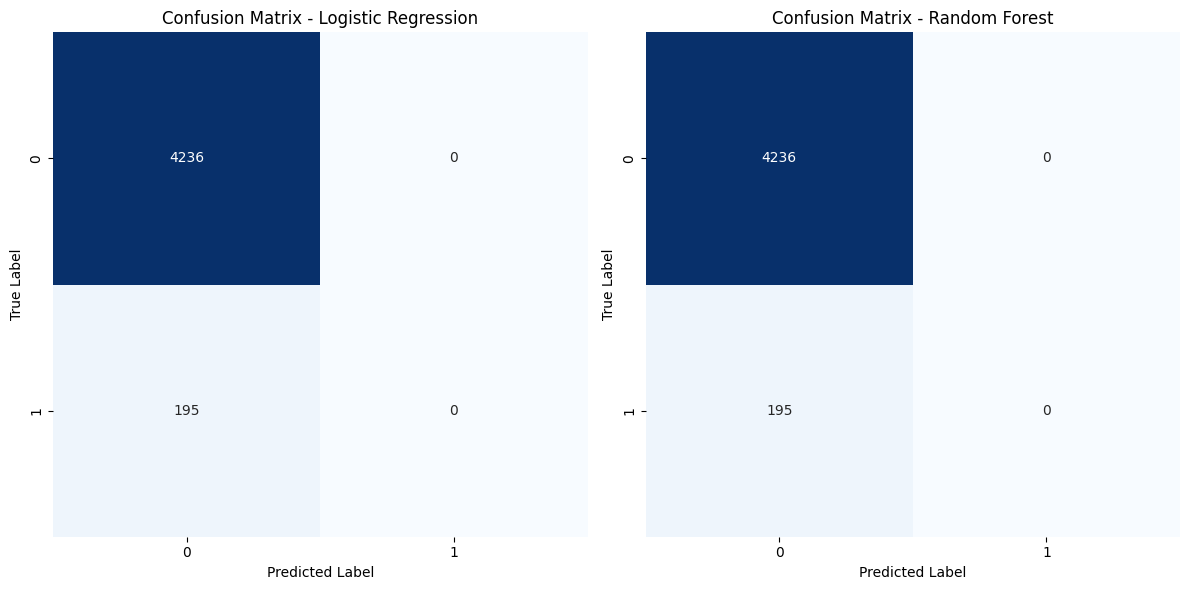

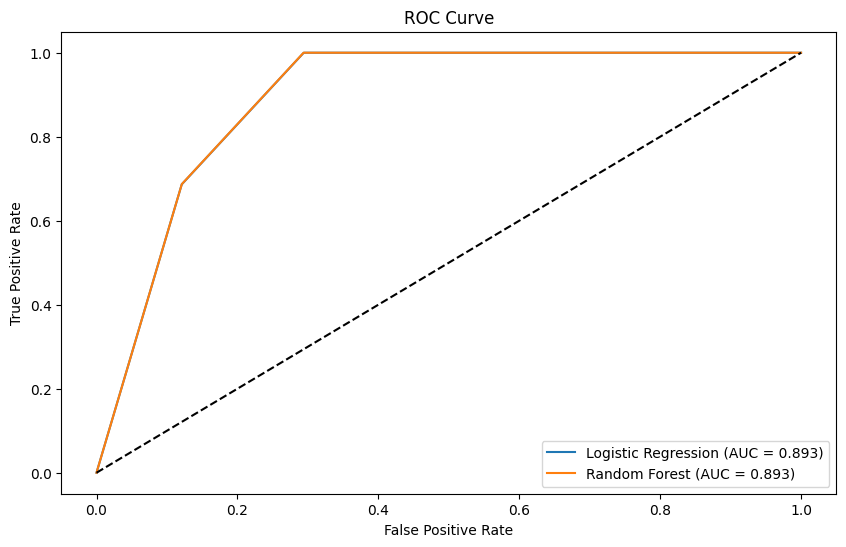

In [81]:
# For Jupyter Notebook, add this magic command at the top of the notebook to render plots inline
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# Plot Confusion Matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test, best_log_reg.predict(X_test))
rf_cm = confusion_matrix(y_test, best_rf.predict(X_test))

plt.figure(figsize=(12, 6))

# Plot confusion matrix for Logistic Regression
plt.subplot(1, 2, 1)
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot confusion matrix for Random Forest
plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# ROC Curve for both models
log_reg_probs = best_log_reg.predict_proba(X_test)[:, 1]
rf_probs = best_rf.predict_proba(X_test)[:, 1]

log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(10, 6))
plt.plot(log_reg_fpr, log_reg_tpr, label='Logistic Regression (AUC = {:.3f})'.format(log_reg_roc_auc))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.3f})'.format(rf_roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
